# Baseline Code for HW1

This is just the baseline code to set up the basic function you need. You need to modify the code yourself to achieve a better result.

## Import packages you need

In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

myseed = 666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## Basic Function
Do not modify this part

In [2]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, ymax, ymin, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim([0 if ymin < 0 else ymin][0], ymax)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()
    
def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('Truth value')
    plt.ylabel('predicted value')
    plt.title('Truth v.s. Prediction')
    plt.show()

## Data and Preprocess
The function below used to:
1. Read the csv files into python
2. Choose features (you can choose yourself)
3. Split data into training and validation sets.
4. Normalization

In [3]:
class Dataprocess(Dataset):
    def __init__(self,
                 path,
                 distribute,
                 m,
                 sd,
                 mode='train',
                 modify=False):
        self.mode = mode

        # Read csv file
        with open(path, 'r') as f:
            data = list(csv.reader(f))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if modify == False:
            feats = list(range(93))
        else:
            # Hint:Feature Selection
            feats = list(range(18)) + list(range(40,44)) + list(range(57,62)) + list(range(75,80))
            
            pass

        if mode == 'test':
            # Testing set
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
            
            #####################
            self.m = m
            self.sd = sd
        else:
            # Training set
            target = data[:, -1]
            data = data[:, feats]

            # Splitting data into training and validation sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % distribute != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % distribute == 0]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])
            
            #################
            if mode == 'train':
                self.m = self.data[:, 18:].mean(dim=0, keepdim=True)
                self.sd = self.data[:, 18:].std(dim=0, keepdim=True)
            elif mode == 'dev':
                self.m = m
                self.sd = sd

        # Normalize features
        ##############
        self.data[:, 18:] = (self.data[:, 18:] - self.m) / self.sd

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

## Dataloader
Loads data into batches.

In [4]:
def dataloader(path, mode, batch_size, distribute, n_jobs=0, modify=False, m=None, sd=None):
    dataset = Dataprocess(path, distribute, m, sd, mode=mode, modify=modify)
    
    #######
    if mode == 'train':
        m = dataset.m
    sd = dataset.sd
    
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)
    return dataloader, m, sd

## Define DNN by pytorch
The DNN consists of 2 fully-connected layers with ReLU activation function

In [5]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        
        # Try to modify this DNN to achieve better performance
        self.net = nn.Sequential(
            #nn.Linear(input_dim, 256),
            #nn.LeakyReLU(),
            #nn.Linear(256, 128),
            #nn.ReLU(),
            #nn.Linear(128, 1)

            nn.Linear(input_dim, 256),
            nn.SiLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # Loss function MSE
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target, alpha):
        ''' Calculate loss '''
        # You may try regularization here
        # + alpha*l2 regularization
        return self.criterion(pred, target) + alpha * self.l2_penalty(pred)
        # return self.criterion(pred, target)
    
    def l2_penalty(self, w):
        return torch.sum(w.pow(2))/2

## Training

In [6]:
def train(tr_set, dv_set, model, config, device, index, alpha):

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y, alpha)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        dev_mse = dev(dv_set, model, device, alpha)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            if (epoch + 1)%10 == 0:
                print('Saving model (epoch = {:4d}, loss = {:.4f})'
                    .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'] + str(index) + '.pth')  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            break
    print('Saving model (epoch = {:4d}, loss = {:.4f})'
                    .format(epoch, min_mse))
    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

## Validation

In [7]:
def dev(dv_set, model, device, alpha):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y, alpha)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## Testing

In [8]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

## Hyper-parameters for DNN


In [9]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
modify = True                        # Need selection

# Tune these hyper-parameters to improve your model
config = {
    'kfold': 5,
    'alpha': 0.00005,
    'distribute':[5,10],             # 8:2/ 1:9
    'n_epochs': 5000,                # maximum number of epochs
    'batch_size': [100,200],               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum':0.1,
        'weight_decay':1e-4
    },
    'early_stop': 400,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model'  # your model will be saved here
}

## Read the dataset

#############1 model #################
#############100 num_batch #################
#############5 distribute #################
Finished reading the train set of COVID19 Dataset (1600 samples found, each dim = 32)
Finished reading the dev set of COVID19 Dataset (400 samples found, each dim = 32)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 32)
Saving model (epoch =   10, loss = 2.5909)
Saving model (epoch =   20, loss = 2.0275)
Saving model (epoch =   30, loss = 1.8975)
Saving model (epoch =   50, loss = 1.7980)
Saving model (epoch =   60, loss = 1.7698)
Saving model (epoch =   70, loss = 1.7466)
Saving model (epoch =  110, loss = 1.6988)
Saving model (epoch =  320, loss = 1.6365)
Saving model (epoch = 1029, loss = 1.6327)
Finished training after 1029 epochs
#############1 plot #################


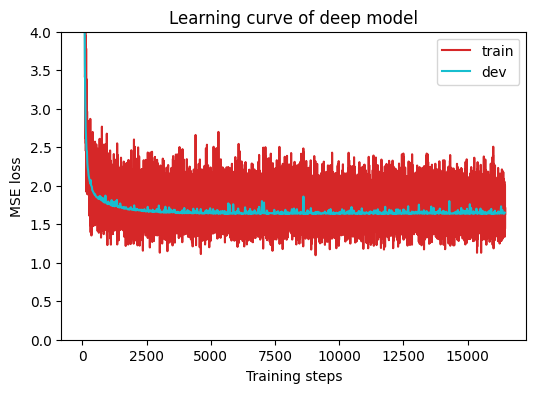

#############2 model #################
#############200 num_batch #################
#############5 distribute #################
Finished reading the train set of COVID19 Dataset (1600 samples found, each dim = 32)
Finished reading the dev set of COVID19 Dataset (400 samples found, each dim = 32)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 32)
Saving model (epoch =   10, loss = 10.7656)
Saving model (epoch =   20, loss = 3.2283)
Saving model (epoch =   30, loss = 2.9142)
Saving model (epoch =   40, loss = 2.7770)
Saving model (epoch =   50, loss = 2.7020)
Saving model (epoch =   60, loss = 2.6491)
Saving model (epoch =   70, loss = 2.6153)
Saving model (epoch =  100, loss = 2.5473)
Saving model (epoch =  110, loss = 2.5343)
Saving model (epoch =  130, loss = 2.5111)
Saving model (epoch =  140, loss = 2.4990)
Saving model (epoch =  150, loss = 2.4868)
Saving model (epoch =  160, loss = 2.4806)
Saving model (epoch =  190, loss = 2.4612)
Saving model (ep

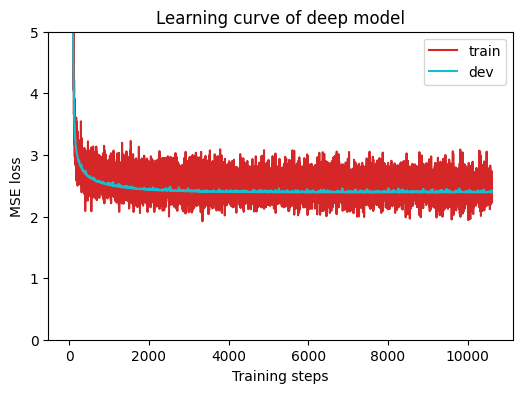

#############3 model #################
#############100 num_batch #################
#############10 distribute #################
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 32)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 32)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 32)
Saving model (epoch =   10, loss = 2.1752)
Saving model (epoch =   20, loss = 1.9588)
Saving model (epoch =   30, loss = 1.8782)
Saving model (epoch =   50, loss = 1.7781)
Saving model (epoch =   60, loss = 1.7583)
Saving model (epoch =  120, loss = 1.6623)
Saving model (epoch =  270, loss = 1.6248)
Saving model (epoch =  766, loss = 1.6217)
Finished training after 766 epochs
#############3 plot #################


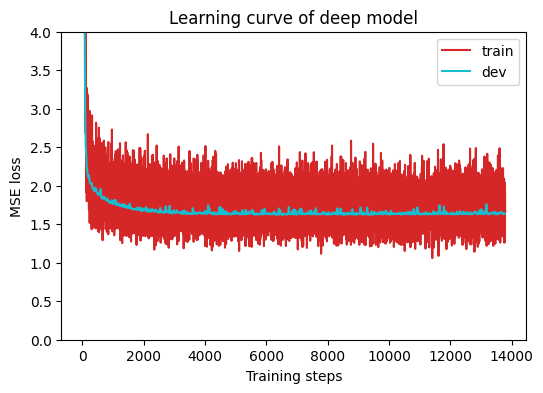

#############4 model #################
#############200 num_batch #################
#############10 distribute #################
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 32)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 32)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 32)
Saving model (epoch =   10, loss = 4.3342)
Saving model (epoch =   20, loss = 2.8988)
Saving model (epoch =   40, loss = 2.6777)
Saving model (epoch =   60, loss = 2.5994)
Saving model (epoch =   70, loss = 2.5818)
Saving model (epoch =   80, loss = 2.5612)
Saving model (epoch =   90, loss = 2.5437)
Saving model (epoch =  100, loss = 2.5331)
Saving model (epoch =  110, loss = 2.5204)
Saving model (epoch =  140, loss = 2.4877)
Saving model (epoch =  160, loss = 2.4703)
Saving model (epoch =  370, loss = 2.3999)
Saving model (epoch =  410, loss = 2.3943)
Saving model (epoch =  490, loss = 2.3889)
Saving model (ep

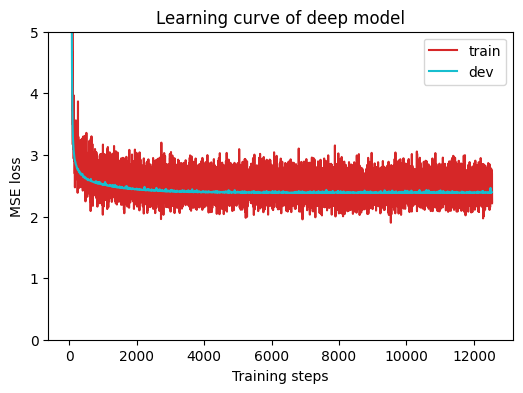

In [10]:
train_path = 'HW1.train.csv'  # path to training data
test_path = 'HW1.test.csv'   # path to testing data
i = 0

for distribute in config['distribute']:
    for batch in config['batch_size']:
        print(f"#############{i+1} model #################")
        print(f"#############{batch} num_batch #################")
        print(f"#############{distribute} distribute #################")
        train_set, train_m, train_sd = dataloader(train_path, 'train', batch, distribute, modify=modify)
        validation_set, v_mean, v_sd = dataloader(train_path, 'dev', batch, distribute, modify=modify, m=train_m, sd=train_sd)
        test_set, test_mean, test_sd = dataloader(test_path, 'test', batch, distribute, modify=modify, m=train_m, sd=train_sd)

        model = NeuralNet(train_set.dataset.dim).to(device)  # Construct model and move to device

        model_loss, model_loss_record = train(train_set, validation_set, model, config, device, i+1, config['alpha'])

        ymax = math.ceil(model_loss_record['train'][int(len(model_loss_record['train'])/2)] + 2)
        ymin = math.floor(model_loss_record['train'][int(len(model_loss_record['train'])/2)] - 2)

        print(f"#############{i+1} plot #################")
        plot_learning_curve(model_loss_record, ymax, ymin, title='deep model')
        
        i += 1
        del model

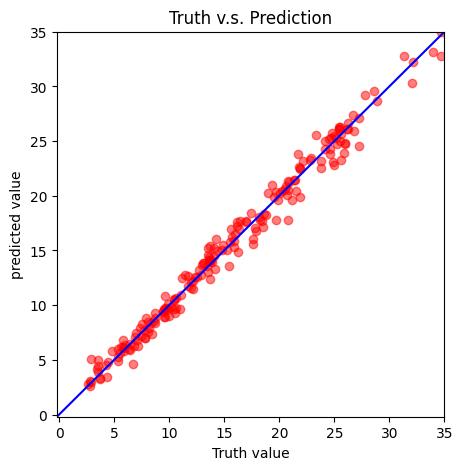

In [11]:
model = NeuralNet(train_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'] + '3.pth', map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(validation_set, model, device)  # Show prediction on the validation set

## Testing
Get the prediction result and save it to csv file named 'prediction.csv'

In [12]:
def save_pred(preds, file):
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(test_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'prediction.csv')         # save prediction file to pred.csv

Saving results to prediction.csv


In [13]:
preds

array([19.028744 , 19.851648 , 11.530631 , 26.990477 ,  8.419935 ,
        9.587376 , 21.265093 , 21.497015 , 12.330673 , 11.302175 ,
       27.757349 , 20.057457 , 12.390354 , 32.015038 , 10.3961935,
       11.521349 , 19.008566 , 15.844868 , 12.8989   , 21.977667 ,
       23.754015 , 23.529314 , 19.251835 , 10.209335 ,  9.930855 ,
       11.685003 , 11.825264 , 26.357683 , 14.796389 , 11.359206 ,
       28.326742 , 18.791105 ,  8.681052 , 14.697092 , 19.99207  ,
       25.97316  , 25.957125 , 10.785754 , 13.018627 , 25.973944 ,
       12.455063 , 15.74789  , 16.662334 , 24.834797 , 24.928005 ,
       22.318005 , 20.867624 , 16.730053 ,  9.955297 , 20.7811   ,
       24.449743 , 20.100443 ,  9.340881 , 16.288471 , 27.459139 ,
       27.725725 , 11.425131 , 23.070272 , 18.607424 , 26.083178 ,
       20.215734 , 16.491943 , 22.583868 , 18.646639 , 20.643078 ,
       21.823965 , 16.811508 , 15.40917  , 13.415861 , 19.855286 ,
       24.679802 , 13.844191 , 11.154541 , 11.245727 , 10.3645

## Hints for better result
* Feature selection done
* DNN architecture 
* Training (mini-batch/optimizer/learning rate)
* Regularization